In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import functools

In [ ]:
# leer las trayectorias generadas
import h5py

data_file = "trayectorias.h5"

with h5py.File(data_file, "r") as hf:
    trayectorias = hf["trayectorias"][:]

# Asegúrate de que las trayectorias se ajusten a tus necesidades específicas
# Si es necesario, puedes transformar los datos en tensores TensorFlow
trayectorias = tf.constant(trayectorias, dtype=tf.float32)
trayectorias

In [ ]:
# n_particula, (posicion,velocidad), tiempo
trayectorias.shape
#TensorShape([300,2,300])

In [ ]:
def plot_trayectoria(trayectorias, N):
    plt.figure(figsize=(5, 3))
    if len(trayectorias.shape) == 2:
        print('one data point')
        plt.plot(trayectorias[0], trayectorias[1], alpha=0.6)

    else:
        for i in range(N):
            plt.plot(trayectorias[i][0], trayectorias[i][1], alpha=0.6)
    plt.xlabel(r'$\psi$')
    plt.ylabel(r'$\omega$')
    plt.title('Trayectorias de las Partículas')
    plt.grid()
    plt.show()

plot_trayectoria(trayectorias, 3)

In [ ]:
trayectorias

# ordenamiento de los datos

In [ ]:
# shape: TensorShape([300, 2, 300])
dataset = tf.data.Dataset.from_tensor_slices(trayectorias)

# Determina los tamaños de tus conjuntos de datos
size = tf.data.experimental.cardinality(dataset).numpy()
print("Total de datos: ", size)
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = int(0.15 * size)

# Mezcla tus datos
dataset = dataset.shuffle(size)

# Divide tus datos en conjuntos de entrenamiento, validación y prueba
train_data = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size)

print('\ttraining size: ', len(train_data))
print('\tvalidation size: ', len(val_data))
print('\ttesting size: ', len(test_data))

# Para obtener el primer elemento
# first_data = next(iter(dataset.take(1)))
# second_data = next(iter(dataset.skip(1).take(1)))

# print("Forma de un solo dato: ", first_data.shape)

# Convertir train_data a un tensor
train_data_tensor = tf.concat(list(train_data), axis=0)

# Imprimir la forma del tensor de entrenamiento
print("Forma del tensor de entrenamiento: ", train_data_tensor.shape)

# Imprimir el tensor de entrenamiento
print("Tensor de entrenamiento: ")
print(train_data_tensor)


forma altermativa de ordenar los datos, tener los inputs y outputs separados,
de manera de utilizar:

```
model.fit(
    X_train, Y_train, validation_data=(X_valid, Y_valid) 
         )
```

In [ ]:
# Separar en train, valid, test
train_data = trayectorias[:210, :, :]
val_data = trayectorias[210:255, :, :]
test_data = trayectorias[255:, :, :]

# Imprimir las formas de los conjuntos de datos
print("Forma del conjunto de entrenamiento: ", train_data.shape)
print("Forma del conjunto de validación: ", val_data.shape)
print("Forma del conjunto de prueba: ", test_data.shape)

# Obtener tensores X_train, P_train, X_valid, P_valid
X_train = train_data[:, 0, :]
P_train = train_data[:, 1, :]
X_valid = val_data[:, 0, :]
P_valid = val_data[:, 1, :]
X_test = test_data[:, 0, :]
P_test = test_data[:, 1, :]

# Imprimir las formas de los tensores
print("Forma de X_train: ", X_train.shape)
print("Forma de P_train: ", P_train.shape)

plot_trayectoria(train_data, 210)

# El modelo

Debido a que este modelo utiliza condiciones iniciales y no las toma como input, significa que el modelo habrá de aprender estas condiciones iniciales,
por tanto solo puede aprender de una curva a la vez


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)

        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, axis=-1) 
        z = self.hidden1(inputs_expanded)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [ ]:
t = tf.range(300, dtype=tf.float32)

In [ ]:
@tf.function
def physics_loss(y_true, y_pred, model, inputs, X_target, P_target, params):
    mu = params.get('mu', 2.0)
    position_weight = params.get('position_weight', 10)
    momentum_weight = params.get('momentum_weight', 5)
    data_weight = params.get('data_weight', 1)
    phys_weight = params.get('phys_weight', 1)

    inputs = tf.expand_dims(inputs, axis=-1)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inputs)
        X_predicted = model(inputs)
        dx_dt = tape.gradient(X_predicted, inputs)
        d2x_dt2 = tape.gradient(dx_dt, inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted
    
    # Physics loss
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))
    
    loss = phys_weight * tf.reduce_mean(tf.square(f))
    loss += position_weight * position_loss
    loss += momentum_weight * momentum_loss
    
    # Data loss (optional, depending on your needs)
    # data_loss = data_weight * tf.reduce_mean(tf.square(y_true - y_pred))
    # loss += data_loss
    
    return loss


In [ ]:
def train(model, inputs, targets, params, optimizer, epochs=100, batch_size=32):
    # Compile the model with the partial physics loss function
    X_target = targets[0]
    P_target = targets[1]

    partial_physics_loss = functools.partial(physics_loss, model=model, 
        X_target=X_target, P_target=P_target, params=params)
    model.compile(optimizer=optimizer, loss=partial_physics_loss)

    # Train the model
    history = model.fit(inputs, X_target, epochs=epochs, batch_size=batch_size)

    return history


In [ ]:
params = {'mu': 2.0, 'position_weight': 10.0, 'momentum_weight': 5.0, 'phys_weight': 1.0}
model = VanderPolModel()
inputs = t
history = train(model, inputs, [X_train[0], P_train[0]], params, optimizer=optimizers.Adam(learning_rate=0.0001))


In [ ]:
# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer, loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)

In [ ]:
physics_loss_metric = metrics.Mean('physics_loss', dtype=tf.float32)
position_loss_metric = metrics.Mean('position_loss', dtype=tf.float32)
momentum_loss_metric = metrics.Mean('momentum_loss', dtype=tf.float32)


def physics_loss(X_target, P_target, X_predicted, dx_dt, mu=2.0, position_weight=10, momentum_weight=5):
    # Calcular las pérdidas individuales
    physics_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))

    physics_loss_metric.update_state(physics_loss)
    position_loss_metric.update_state(position_loss)
    momentum_loss_metric.update_state(momentum_loss)

    # Devuelve la suma ponderada de las pérdidas
    return physics_loss + position_weight * position_loss + momentum_weight * momentum_loss

# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer.adam(), loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)


In [ ]:
# Compilar el modelo con múltiples funciones de pérdida
model = VanderPolModel()
inputs = t


# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=partial_physics_loss, 
    metrics=[physics_loss_metric, position_loss_metric,momentum_loss_metric])


# Entrenar el modelo con tus datos (asegúrate de tener X_train y P_train preparados)
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)



In [ ]:
print(history.history.keys())

In [ ]:
import pandas as pd

pd.DataFrame(history.history)

# Modelo Multi Curva
El desarrollo original, pero el problema de 1 input lo hace inviable

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)
        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        z = self.hidden1(inputs)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [ ]:
# La entrada es fija
t = tf.range(300, dtype=tf.float32)
# Copiar el tensor horizontalmente
t_matrix = tf.tile(tf.expand_dims(t, axis=0), [300, 1])

# Ver la forma del tensor resultante
print(t_matrix)

$$
\frac{d^2 x}{dt^2} - \mu(1-x^2) \frac{dx}{dt} +x = 0
$$

In [ ]:
def physics_loss(model, inputs, X_target, P_target, mu=2.0, position_weight=10, momentum_weight=5):
    inputs= tf.expand_dims(inputs, axis=-1)  # Expandir dimensiones

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inputs)
        X_predicted = model(inputs)
        dx_dt = tape.gradient(X_predicted, inputs)
        d2x_dt2 = tape.gradient(dx_dt, inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted

    # Calcular la pérdida
    loss = tf.reduce_mean(tf.square(f))
    loss += position_weight*tf.reduce_mean(tf.square(X_target[:,0] - X_predicted[:,0]))
    loss += momentum_weight*tf.reduce_mean(tf.square(P_target[:,0] - dx_dt[:,0]))

    return loss


model = VanderPolModel()
inputs = t_matrix[:210]
loss = physics_loss(model, inputs, X_train, P_test)

print("Perdida Escalar:", loss)

In [ ]:
# Definir el modelo y el optimizador
model = VanderPolModel()
optimizer = optimizers.Adam(learning_rate=0.001)

# Número de épocas y tamaño del lote
epochs = 100
batch_size = 32

# Bucle de entrenamiento
for epoch in range(epochs):
    # Mezclar y dividir los datos en lotes
    indices = tf.range(210)  # Asegúrate de tener el rango correcto
    tf.random.shuffle(indices)
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i : i + batch_size]
        inputs_batch = tf.gather(inputs, batch_indices)
        X_train_batch = tf.gather(X_train, batch_indices)
        P_train_batch = tf.gather(P_train, batch_indices)

        # Calcular la pérdida y los gradientes
        with tf.GradientTape() as tape:
            loss = physics_loss(model, inputs_batch, X_train_batch, P_train_batch)
        gradients = tape.gradient(loss, model.trainable_variables)

        # Aplicar los gradientes usando el optimizador
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Imprimir la pérdida al final de cada época
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.numpy()}")

# Verificar la pérdida final
final_loss = physics_loss(model, inputs, X_train, P_train)
print("Pérdida final:", final_loss.numpy())


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.tanh, input_shape=(1,)),  # Input layer (time)
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(1) # output position
])

def initial_value_loss(y_true, y_pred):
    # Condición de borde
    return tf.square(y_true[0] - y_pred[0])

def point_loss(y_true, y_pred):
    # Loss function for every point
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile the model
model.compile(optimizer='adam', loss=[initial_value_loss, point_loss])

In [ ]:
x_pred = next(iter(train_data.take(1)))[0,:]
v_pred = next(iter(train_data.take(1)))[1,:]

In [ ]:
x_pred.shape

In [ ]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=100)

# un optimizador

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner

# Supongamos que tus datos están en el tensor 'trayectorias'
trayectorias

# Separa tus datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(trayectorias, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

def build_model(hp):
    # aqui va la construccion del modelo
    model = tf.keras.models.Sequential()
    
    # Añade tus capas aquí. Por ejemplo:
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # una sola salida para predecir la posición

    # Ajusta los hiperparámetros del optimizador Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
    hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2),
                loss=tf.keras.losses.MeanSquaredError(),  # usa MSE para la regresión
                metrics=['mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='mse',  # minimiza el error cuadrático medio
    max_trials=5,
    executions_per_trial=3)

tuner.search(train_data, epochs=60, validation_data=val_data)

# Obtén los hiperparámetros óptimos
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"La tasa de aprendizaje óptima para el optimizador es {best_hps.get('learning_rate')}.")
print(f"El beta_1 óptimo para el optimizador es {best_hps.get('beta_1')}.")
print(f"El beta_2 óptimo para el optimizador es {best_hps.get('beta_2')}.")


## Alternativa

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Paso 1: Implementar el modelo

In [3]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),  # 1 neurona de entrada
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(1)  # 1 neurona de salida
    ])
    return model

In [4]:
# Función de Van der Pol unidimensional
def van_der_pol(x, mu):
    dxdt = mu * (1 - x**2) * x
    return dxdt

In [5]:
def custom_loss(y_true, y_pred):
    # Pérdida de la ecuación de Van der Pol
    t_values = tf.range(0, tf.shape(y_true)[0])  # Secuencia de tiempo
    loss_van_der_pol = tf.reduce_mean(tf.square(y_true - y_pred - h * van_der_pol(y_pred, mu)))
    
    # Pérdida de la condición inicial
    loss_initial_condition = tf.reduce_sum(tf.square(y_true[0, 0] - y_pred[0, 0]))
    
    # Peso para equilibrar ambas pérdidas
    alpha = 0.1
    
    # Pérdida total
    loss = loss_van_der_pol + alpha * loss_initial_condition
    
    return loss


In [6]:
# Parámetros
mu = 2.0
h = 0.01  # Tamaño del paso
num_samples = 1000

In [10]:
# Generar datos de entrenamiento
initial_condition = np.array([1.0])

# y_train_input debe ser bidimensional
y_train_input = np.zeros((num_samples, 1))

# Generar y_train_output directamente sin necesidad de concatenate
y_train_output = np.zeros((num_samples, 1))
y_train_output[0] = initial_condition
for i in range(1, num_samples):
    y_train_output[i] = mu * (1 - y_train_output[i-1]**2) * y_train_output[i-1]

# Asegurar que y_train_output sea bidimensional
y_train_output = np.expand_dims(y_train_output, axis=-1)

In [11]:
# Crear y entrenar el modelo
model = create_model()
model.compile(optimizer='adam', loss=custom_loss)
model.fit(y_train_input, y_train_output, epochs=100, verbose=0)

32/32 [==============================] - 0s 896us/step


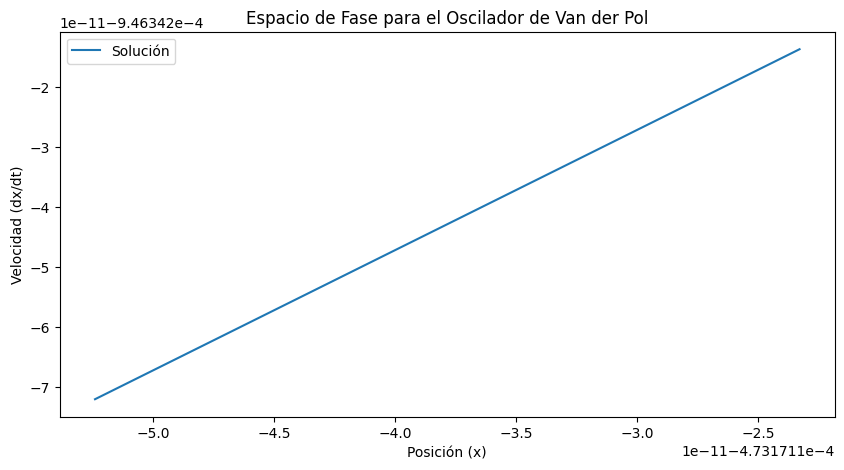

In [12]:
# Resolver la ecuación diferencial usando el modelo entrenado
solution = model.predict(y_train_input)

# Visualizar la solución en el espacio de fase
plt.figure(figsize=(10, 5))
plt.plot(solution[:, 0], van_der_pol(solution[:, 0], mu), label='Solución')
plt.title('Espacio de Fase para el Oscilador de Van der Pol')
plt.xlabel('Posición (x)')
plt.ylabel('Velocidad (dx/dt)')
plt.legend()
plt.show()